<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/Fine_Tune_SimCLR_Pytorch_XLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

In [ ]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

from google.colab import auth, drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

In [ ]:
# Mount Drive
drive.mount('/content/drive')
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch_xla.utils.serialization as xser

In [ ]:
import gdown

def download(data, url):
    # Download dataset
    import zipfile
    url = url
    output = "{}.zip".format(data)
    gdown.download(url, output, quiet=False)

    # Uncompress dataset
    local_zip = '{}.zip'.format(data)
    zip_ref = zipfile.ZipFile(local_zip, "r")
    zip_ref.extractall()
    zip_ref.close()

In [ ]:
data_samples = {
    "sample@200": "https://drive.google.com/uc?id=1FfV7YyDJvNUCDP5r3-8iQfZ2-xJp_pgb",
    "sample@500": "https://drive.google.com/uc?id=1dHwUqpmSogEdjAB9rwDUL-OKFRUcVXte",
    "sample@1000": "https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2",
    "sample@2000": "https://drive.google.com/uc?id=1PB7uGd-dUnZKnKZpZl-HvE1DVcWgX50F",
    "sample@3000": "https://drive.google.com/uc?id=1_yre5K9YYvJgSrT4xvrI8eD_htucIywA",
    "sample@4000_images": "https://drive.google.com/uc?id=1dqVB8EozEpwWzyuU80AauoQmsiw3Gtm2",
    "sample@20000": "https://drive.google.com/uc?id=1MTDpLzpmhSiZq2jSdmHx2UDPn9FC8gzO",
    "val-voets-tf": "https://drive.google.com/uc?id=1VzVgMGTkBBPG2qbzLunD9HvLzH6tcyrv",
    "train_voets": "https://drive.google.com/uc?id=1AmcFh1MOOZ6aqKm2eO7XEdgmIEqHKTZ5",
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd"
}

In [ ]:
UNLABELED = 'sample@1000'

In [ ]:
URL_UNLABELED = data_samples[UNLABELED]
download(UNLABELED, URL_UNLABELED)

Downloading...
From: https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2
To: /content/sample@1000.zip
108MB [00:00, 148MB/s] 


In [ ]:
import args_parse

SUPPORTED_MODELS = [
    'alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201',
    'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34',
    'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13',
    'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
]

MODEL_OPTS = {
    '--model': {
        'choices': SUPPORTED_MODELS,
        'default': 'resnet50',
    },
    '--test_set_batch_size': {
        'type': int,
    },
    '--lr_scheduler_type': {
        'type': str,
    },
    '--lr_scheduler_divide_every_n_epochs': {
        'type': int,
    },
    '--lr_scheduler_divisor': {
        'type': int,
    },
    '--test_only_at_end': {
        'action': 'store_true',
    },
}

In [ ]:
FLAGS = args_parse.parse_common_options(
    datadir=UNLABELED,
    batch_size=None,
    num_epochs=None,
    momentum=None,
    lr=None,
    target_accuracy=None,
    profiler_port=9012,
    opts=MODEL_OPTS.items(),
)

In [ ]:
FLAGS.fake_data = False
FLAGS.num_epochs = 200
FLAGS.batch_size = 64
FLAGS.log_steps = 100
FLAGS.num_cores = 8

In [ ]:
import os
import schedulers
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch_xla
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils

In [ ]:
DEFAULT_KWARGS = dict(
    batch_size=128,
    test_set_batch_size=64,
    num_epochs=200,
    momentum=0.9,
    lr=0.05,
    target_accuracy=0.0,
)
MODEL_SPECIFIC_DEFAULTS = {
    # Override some of the args in DEFAULT_KWARGS, or add them to the dict
    # if they don't exist.
    'resnet50':
        dict(
            DEFAULT_KWARGS, **{
                'lr': 0.05,
                'lr_scheduler_divide_every_n_epochs': 20,
                'lr_scheduler_divisor': 5,
                'lr_scheduler_type': 'WarmupAndExponentialDecayScheduler',
            })
}

In [ ]:
# Set any args that were not explicitly given by the user.
default_value_dict = MODEL_SPECIFIC_DEFAULTS.get(FLAGS.model, DEFAULT_KWARGS)
for arg, value in default_value_dict.items():
  if getattr(FLAGS, arg) is None:
    setattr(FLAGS, arg, value)

In [ ]:
default_value_dict

{'batch_size': 128,
 'lr': 0.05,
 'lr_scheduler_divide_every_n_epochs': 20,
 'lr_scheduler_divisor': 5,
 'lr_scheduler_type': 'WarmupAndExponentialDecayScheduler',
 'momentum': 0.9,
 'num_epochs': 200,
 'target_accuracy': 0.0,
 'test_set_batch_size': 64}

In [ ]:
def get_model_property(key):
  default_model_property = {
      'img_dim': 224,
      'model_fn': getattr(torchvision.models, FLAGS.model)
  }
  model_properties = {
      'inception_v3': {
          'img_dim': 299,
          'model_fn': lambda: torchvision.models.inception_v3(aux_logits=False)
      },
  }
  model_fn = model_properties.get(FLAGS.model, default_model_property)[key]
  return model_fn

In [ ]:
def _train_update(device, step, loss, tracker, epoch, writer):
  test_utils.print_training_update(
      device,
      step,
      loss.item(),
      tracker.rate(),
      tracker.global_rate(),
      epoch,
      summary_writer=writer)


def train_imagenet():
  print('==> Preparing data..')
  img_dim = get_model_property('img_dim')
  if FLAGS.fake_data:
    train_dataset_len = 1200000  # Roughly the size of Imagenet dataset.
    train_loader = xu.SampleGenerator(
        data=(torch.zeros(FLAGS.batch_size, 3, img_dim, img_dim),
              torch.zeros(FLAGS.batch_size, dtype=torch.int64)),
        sample_count=train_dataset_len // FLAGS.batch_size //
        xm.xrt_world_size())
    test_loader = xu.SampleGenerator(
        data=(torch.zeros(FLAGS.test_set_batch_size, 3, img_dim, img_dim),
              torch.zeros(FLAGS.test_set_batch_size, dtype=torch.int64)),
        sample_count=50000 // FLAGS.batch_size // xm.xrt_world_size())
  else:
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    train_dataset = torchvision.datasets.ImageFolder(
        os.path.join(FLAGS.datadir, 'train'),
        transforms.Compose([
            transforms.RandomResizedCrop(img_dim),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))
    train_dataset_len = len(train_dataset.imgs)
    resize_dim = max(img_dim, 256)


    train_sampler, test_sampler = None, None
    if xm.xrt_world_size() > 1:
      train_sampler = torch.utils.data.distributed.DistributedSampler(
          train_dataset,
          num_replicas=xm.xrt_world_size(),
          rank=xm.get_ordinal(),
          shuffle=True)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=FLAGS.batch_size,
        sampler=train_sampler,
        drop_last=FLAGS.drop_last,
        shuffle=False if train_sampler else True,
        num_workers=FLAGS.num_workers)

  torch.manual_seed(42)

  device = xm.xla_device()
  model = get_model_property('model_fn')().to(device)

  model.fc = nn.Sequential(
        nn.Linear(2048, 512),
        nn.Linear(512, 1),
        nn.Sigmoid()
    ).to(device)

  state_dict = xser.load('/content/drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-70.pt')

  for k in list(state_dict.keys()):

    if k.startswith('backbone.'):
      if k.startswith('backbone') and not k.startswith('backbone.fc'):
        # remove prefix
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]

  log = model.load_state_dict(state_dict, strict=False)

  writer = None
  if xm.is_master_ordinal():
    writer = test_utils.get_summary_writer(FLAGS.logdir)
  optimizer = optim.SGD(
      model.parameters(),
      lr=FLAGS.lr,
      momentum=FLAGS.momentum,
      weight_decay=1e-4)
  num_training_steps_per_epoch = train_dataset_len // (
      FLAGS.batch_size * xm.xrt_world_size())
  lr_scheduler = schedulers.wrap_optimizer_with_scheduler(
      optimizer,
      scheduler_type=getattr(FLAGS, 'lr_scheduler_type', None),
      scheduler_divisor=getattr(FLAGS, 'lr_scheduler_divisor', None),
      scheduler_divide_every_n_epochs=getattr(
          FLAGS, 'lr_scheduler_divide_every_n_epochs', None),
      num_steps_per_epoch=num_training_steps_per_epoch,
      summary_writer=writer)
  

  #loss_fn = nn.CrossEntropyLoss()
  loss_fn = nn.BCELoss()

  def train_loop_fn(loader, epoch):
    tracker = xm.RateTracker()
    model.train()
    for step, (data, target) in enumerate(loader):

      optimizer.zero_grad()
      output = model(data)

      target = target.unsqueeze(1) ## YO
      target = target.float() # YOO

      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS.batch_size)
      if lr_scheduler:
        lr_scheduler.step()
      if step % FLAGS.log_steps == 0:
        xm.add_step_closure(
            _train_update, args=(device, step, loss, tracker, epoch, writer))

  train_device_loader = pl.MpDeviceLoader(train_loader, device)

  for epoch in range(1, FLAGS.num_epochs + 1):
    xm.master_print('Epoch {} train begin {}'.format(epoch, test_utils.now()))
    train_loop_fn(train_device_loader, epoch)
    xm.master_print('Epoch {} train end {}'.format(epoch, test_utils.now()))

    if FLAGS.metrics_debug:
      xm.master_print(met.metrics_report())

  test_utils.close_summary_writer(writer)

  xm.master_print("Finished training")

  xm.save(
            model.state_dict(),
            "drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-Finetuned-Test.pt"
        )

  return 0

In [ ]:
def _mp_fn(index, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  ans = train_imagenet()

In [ ]:
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

==> Preparing data..
==> Preparing data..
==> Preparing data..
==> Preparing data..
==> Preparing data..
==> Preparing data..
==> Preparing data..
==> Preparing data..
Epoch 1 train begin 03:32:14
| Training Device=xla:0/2 Epoch=1 Step=0 Loss=0.68646 Rate=4.74 GlobalRate=4.74 Time=03:32:32
| Training Device=xla:0/5 Epoch=1 Step=0 Loss=0.69463 Rate=10.19 GlobalRate=10.19 Time=03:32:32
| Training Device=xla:1/0 Epoch=1 Step=0 Loss=0.69235 Rate=3.58 GlobalRate=3.58 Time=03:32:32
| Training Device=xla:0/3 Epoch=1 Step=0 Loss=0.69339 Rate=8.80 GlobalRate=8.80 Time=03:32:32
| Training Device=xla:0/4 Epoch=1 Step=0 Loss=0.68110 Rate=7.35 GlobalRate=7.35 Time=03:32:32
| Training Device=xla:0/6 Epoch=1 Step=0 Loss=0.68771 Rate=12.00 GlobalRate=12.00 Time=03:32:32
| Training Device=xla:0/1 Epoch=1 Step=0 Loss=0.68265 Rate=18.89 GlobalRate=18.89 Time=03:32:32
| Training Device=xla:0/7 Epoch=1 Step=0 Loss=0.68425 Rate=40.34 GlobalRate=40.34 Time=03:32:32
Epoch 1 train end 03:32:33
Epoch 2 train be

---

## Test SimCLR

In [ ]:
device = xm.xla_device()
model = get_model_property('model_fn')().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.Linear(512, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
state_dict = xser.load('/content/drive/MyDrive/Colab Notebooks/SimCLR/models/SimCLR-1-DR-pytorch/net-DR-SimCLR-Finetuned-Test.pt')

In [ ]:
state_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.wei

In [ ]:
for k in list(state_dict.keys()):
    if k.startswith('backbone.'):
        if k.startswith('backbone') and not k.startswith('backbone.fc'):
            # remove prefix
            state_dict[k[len("backbone."):]] = state_dict[k]
del state_dict[k]

In [ ]:
log = model.load_state_dict(state_dict, strict=False)

In [ ]:
log

_IncompatibleKeys(missing_keys=['fc.1.bias'], unexpected_keys=[])

In [ ]:
import zipfile
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
test_data = {
    "voets_test_images": "https://drive.google.com/uc?id=15S_V3B_Z3BOjCT3AbO2c887FyS5B0Lyd",
    "messidor2": "https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p",
}

TEST_DATASET = 'messidor2'
URL_TEST_DATASET = test_data[TEST_DATASET]

In [ ]:
!gdown $URL_TEST_DATASET

Downloading...
From: https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p
To: /content/messidor2.zip
106MB [00:00, 116MB/s] 


In [ ]:
local_zip = '{}.zip'.format(TEST_DATASET)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

In [ ]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)  # What happens if I change This 
])

In [ ]:
test_dataset = datasets.ImageFolder(root="messidor2", transform=transform_val) # root: test/messidor2

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=1,
    shuffle=False)

loader = test_loader

In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    with tqdm(total=len(loader)) as pbar:
        for batch_idx, (inputs, targets) in enumerate(loader):

            model.eval()

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            output = output.to(device)

            # Yo le agrege esto
            y_true.append(targets.cpu().detach().numpy()[0])
            y_pred.append(output.cpu().detach().numpy()[0][0])

            pbar.update(1)

100%|██████████| 1748/1748 [01:02<00:00, 27.91it/s]


In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.8628097106802094

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


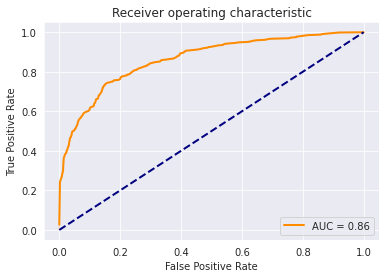

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
# %matplotlib inline

#cm=metrics.confusion_matrix(y_true, y_pred)
auc = metrics.auc(fpr, tpr)
#print('AUC: %.3f' % auc)
#print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

# Plot ROC curve
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax1 = sns.lineplot(fpr, tpr, color='darkorange',
        lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax1.set_title('Receiver operating characteristic')
ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()